In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
#import mpl_pboc
#mpl_pboc.plotting_style()

#from matplotlib import font_manager
#font_manager.fontManager.addfont('../misc/lucida-sans-unicode.ttf')

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Making information footprints

In [6]:
def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, rep_emat, P, R, M, N,
                  ep_wt=0, er_wt=0, ep_NS=0, er_NS=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep_mut = mut[rep_start:rep_end].upper()
        rv['pbound'] = tregs.simulate.simrep_pbound_cp(
                            rnap_mut, rep_mut, rnap_emat, rep_emat, P, R, M, N,
                            ep_wt=ep_wt, er_wt=er_wt, ep_NS=ep_NS, er_NS=er_NS)
        
        l_tr.append(rv)
    df_simrep = pd.DataFrame.from_records(l_tr)

    return df_simrep


def get_dna_cnt(n_seqs):

    dna_cnt = np.random.exponential(1, size=n_seqs) * 10

    dna_cnt_up = []
    for cnt in dna_cnt:
        dna_cnt_up.append(math.ceil(cnt))

    return dna_cnt


def simrep_cp(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, rep_emat, 
           ep_wt, er_wt, P, R, M, N,
           num_mutants=10000, mutrate=0.1, scaling_factor=100,
           ep_NS=0, er_NS=0):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq,rep_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                            rnap_emat, rep_emat, P, R, M, N,
                            ep_wt=ep_wt, er_wt=er_wt, ep_NS=ep_NS, er_NS=er_NS)
    
    dna_cnt = get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)

    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

## Simulate dataset and information footprint

In [7]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 10
N = len(genome)

df = simrep_cp(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
               ep_wt, er_wt, P, R, M, N)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

In [8]:
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

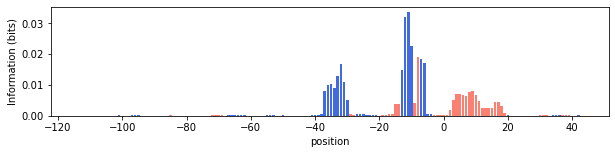

In [9]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [10]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 50
N = len(genome)

df = simrep_cp(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
               ep_wt, er_wt, P, R, M, N)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

In [11]:
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

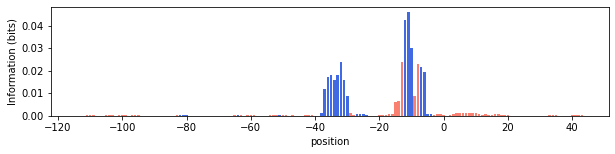

In [12]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [13]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 100
N = len(genome)

df = simrep_cp(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
               ep_wt, er_wt, P, R, M, N)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

In [14]:
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

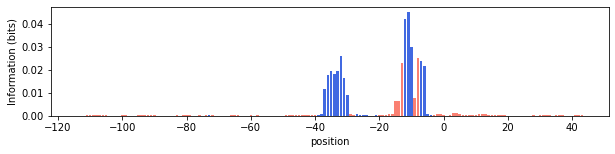

In [15]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()